
# ATTENTION-LSTM Forecasting with VMD Decomposition on ETTh1 Dataset

In this experiment, we use the ETTh1 dataset (Electricity Transformer Temperature, hourly data) to forecast the oil temperature (OT).
We first apply **Variational Mode Decomposition (VMD)** to extract intrinsic mode components (IMFs) from the `OT` series, 
then use an **Attention-based LSTM (Attn-LSTM)** to capture temporal dependencies and focus on informative time steps.



## Import-Params-Read-Visualization

In [8]:
# Parameters
SEQ_LEN = 24  # past 24 hours for each sample
TARGET_COL = 'OT'  # target variable: Oil Temperature
EPOCHS = 30 
BATCH_SIZE = 32

# VMD parameters
DC = 0              # no DC part imposed
init = 1            # initialize omegas uniformly
tol = 1e-7
K = 4                    # number of VMD modes (tuneable)
alpha = 2000             # VMD alpha (tuneable)
tau = 0.0                # VMD tau

LSTM_UNITS = 128
DROPOUT = 0.2
LEARNING_RATE = 1e-3

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from vmdpy import VMD
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [4]:
save_dir = os.path.expanduser("~/Project/AttnLstm/data/raw")
os.makedirs(save_dir, exist_ok=True)
# Full file path
file_path = os.path.join(save_dir, "ETTh1.csv")
# Load it whenever needed
df = pd.read_csv(file_path)
print(df.head())
df.columns = df.columns.str.strip().str.replace('\ufeff', '')
print(df.columns)
# Ensure datetime type
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
data = df[[TARGET_COL]].values


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


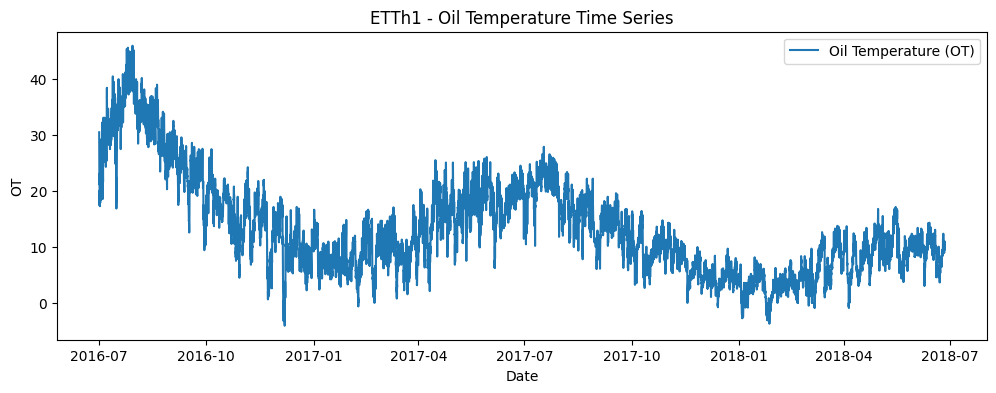

In [5]:
# Visualize
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['OT'], label='Oil Temperature (OT)')
plt.title('ETTh1 - Oil Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

## X,Y  and Train_test_split Simple

In [16]:
# =====================================================
# Split Train/Test
# =====================================================
split_idx = int(len(df) * 0.8)
train_data = df[:split_idx]
test_data  = df[split_idx:]
# =====================================================
# Helper for VMD-based training data
# =====================================================
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    limit = min(len(X), len(y)) - seq_len
    for i in range(limit):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

    
def train_test(alpha=1, tau=1, K=1):
    # --- VMD on train and test ---
    u_train, _, _ = VMD(train_data[TARGET_COL].values, alpha, tau, K, DC=0, init=1, tol=1e-7)
    u_test,  _, _ = VMD(test_data[TARGET_COL].values,  alpha, tau, K, DC=0, init=1, tol=1e-7)

    vmd_train = np.stack(u_train, axis=1)
    vmd_test  = np.stack(u_test,  axis=1)

    # --- Scale features & target ---
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    train_scaled_vmd = scaler_x.fit_transform(vmd_train)
    train_scaled_target = scaler_y.fit_transform(train_data[[TARGET_COL]])
    test_scaled_vmd  = scaler_x.transform(vmd_test)
    test_scaled_target  = scaler_y.transform(test_data[[TARGET_COL]])

    # --- Sequence generation (aligned) ---
    X_train_vmd, y_train_vmd = create_sequences(train_scaled_vmd, train_scaled_target, SEQ_LEN)
    X_test_vmd,  y_test_vmd  = create_sequences(test_scaled_vmd,  test_scaled_target,  SEQ_LEN)
    X_train_simple, y_train_simple = create_sequences(train_scaled_target,train_scaled_target,SEQ_LEN)
    X_test_simple, y_test_simple = create_sequences(test_scaled_target,test_scaled_target,SEQ_LEN)
    y_test_simple_true = scaler_y.inverse_transform(y_test_simple.reshape(-1, 1)).flatten()
    y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd)


    # ✅ Align lengths with simple test (optional for comparison)
    # min_len = min(len(y_test_vmd_seq), len(y_test_simple_seq))
    # y_test_vmd_seq = y_test_vmd_seq[-min_len:]
    # y_test_simple_seq = y_test_simple_seq[-min_len:]
    # X_test_vmd_seq = X_test_vmd_seq[-min_len:]

    return y_test_vmd_true,y_test_simple_true,scaler_y,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,X_train_simple,y_train_simple,X_test_simple,y_test_simple


# AttnLSTM+VMD+GA
    - VMD parameters (like alpha, K, tau, etc.)

    - Model parameters (like number of LSTM units, learning rate, dropout, etc.)

We’ll use a Genetic Algorithm (GA) for joint optimization of both sets.

#### Why this architecture?

- The **stacked LSTM layers** capture hierarchical temporal‑dependencies within the input sequence.  
- The **Attention() layer** allows the model to dynamically focus on different time‑steps of the sequence (via self‑attention over the LSTM outputs).  
- By extracting both the **last output** and the **mean of the attention context**, the model combines both “summary” information and distributed attention information.  
- This **hybrid structure (LSTM + Attention)** is especially useful in non‑stationary, complex time series where long‑range dependencies and varying importance of past steps matter.


## Relevant Papers on Attention-LSTM (AttLSTM) based on my Architecture Implementation

Here are some peer-reviewed, indexed papers that implement LSTM with attention (Attention-LSTM / AttLSTM):

1. **Attention‑based LSTM network‑assisted time series forecasting models for petroleum production**  
   - *Kumar et al., 2023, Engineering Applications of Artificial Intelligence, Vol 123, Article 106440*  
   - Applies LSTM with attention for time-series forecasting in petroleum production.  
   - [Link to article](https://dl.acm.org/doi/abs/10.1016/j.engappai.2023.106440?utm_source=chatgpt.com)  
   - **JCR-indexed**.

2. **Time series prediction model based on LSTM-attention-LSTM model**  
   - *Wen & Li, 2023, IEEE Access*  
   - Proposes an encoder-decoder LSTM with attention mechanism in between.  
   - [Link to article](https://doaj.org/article/a0f2861a315340bcbb4f985c015da50e?utm_source=chatgpt.com)  
   - Fully peer-reviewed and indexed.

3. **Multivariate Time Series Data Prediction Based on ATT-LSTM Model**  
   - *Ju et al., 2021, Applied Sciences (MDPI), Vol 11, 20, 9373*  
   - Implements ATT-LSTM for multivariate time series prediction.  
   - [Link to article](https://www.mdpi.com/2076-3417/11/20/9373?utm_source=chatgpt.com)  
   - Peer-reviewed, open-access journal.

> **Note:** These papers validate the use of Attention-LSTM models in forecasting tasks. Variations may exist in attention mechanisms (temporal, variable) and encoder-decoder designs.


## Relevant Papers on VMD + GA Hybrid Methods

Here are some peer-reviewed / indexed papers that implement VMD (Variational Mode Decomposition) combined with GA (Genetic Algorithm) for forecasting or signal decomposition:

1. **A genetic algorithm optimized hybrid model for agricultural price forecasting based on VMD and LSTM network**  
   - Applies GA-optimised VMD to decompose agricultural commodity price series, then uses LSTM for prediction.  
   - GA is used to optimise VMD parameter selection.  
   - Application domain: agricultural commodity prices (maize, palm oil, soybean oil).  
   - [PubMed link](https://pubmed.ncbi.nlm.nih.gov/40121306/?utm_source=chatgpt.com)  

2. **Variational Mode Decomposition based Machine Learning Models Optimized with Genetic Algorithm for Price Forecasting**  
   - Authors: Pankaj Das, Achal Lama, Girish Kumar Jha  
   - Published in: *Journal of the Indian Society of Agricultural Statistics*, 76(3), 2022, pp141–150  
   - Uses VMD + GA hybrid ML models (SVR + RF) for price forecasting.  
   - [Link to PDF](https://krishi.icar.gov.in/jspui/bitstream/123456789/76648/1/VMD-GA%20based%20ML%20models.pdf?utm_source=chatgpt.com)  

3. **Short-term power grid load forecasting based on optimized VMD and GA-BP**  
   - Published in: *International Journal of Low-Carbon Technologies*  
   - Application: short-term load forecasting in regional power grids using VMD and GA-optimized backpropagation (BP) network.  
   - [Oxford Academic link](https://academic.oup.com/ijlct/article/doi/10.1093/ijlct/ctae039/7644400?utm_source=chatgpt.com)  

4. **Wind power forecasting based on improved variational mode decomposition and permutation entropy**  
   - Refers to GA-VMD stacking in wind power forecasting models.  
   - Published in: *Clean Energy*  
   - Application: wind power prediction.  
   - [Link](https://academic.oup.com/ce/article/7/5/1032/7279331?utm_source=chatgpt.com)  

5. **A hybrid forecasting method for quantitative investments based on GA-VMD and SSA-DELM optimization**  
   - Authors: Ruitian Zhang, Zebang Deng, Yicheng Shen  
   - Published in: *Business & Management*, Vol 33  
   - Application: quantitative investment modelling using GA-optimized VMD.  
   - [Link](https://bcpublication.org/index.php/BM/article/view/2730?utm_source=chatgpt.com)  

> **Note:** These papers demonstrate the use of GA to optimize VMD parameters before applying ML models (LSTM, BP, SVR, etc.) for forecasting or signal decomposition.


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from vmdpy import VMD
import random

# =====================================================
# 1️⃣ Global Config
# =====================================================
SEQ_LEN = SEQ_LEN        # sequence length
EPOCHS_OPT = 4           # epochs during GA fitness
EPOCHS_FINAL = EPOCHS    # final retraining

# =====================================================
# 2️⃣ ATT-LSTM Model Builder
# =====================================================
def build_attlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32):
    inp = Input(shape=input_shape)
    lstm_out = LSTM(lstm1_units, return_sequences=True)(inp)
    lstm_out = Dropout(0.2)(lstm_out)

    # Attention
    query = Dense(lstm1_units)(lstm_out)
    value = Dense(lstm1_units)(lstm_out)
    attention_out = Attention()([query, value])
    attention_out = Concatenate()([lstm_out, attention_out])

    # Decoder
    lstm_dec = LSTM(lstm2_units, return_sequences=False)(attention_out)
    dense_out = Dense(dense_units, activation='relu')(lstm_dec)
    final_out = Dense(1)(dense_out)

    model = Model(inputs=inp, outputs=final_out)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
    return model

# =====================================================
# 4️⃣ Fitness Function (GA objective)
# =====================================================
def fitness(params, data):
    alpha, tau, K = params['alpha'], params['tau'], params['K']
    lstm1_units, lstm2_units, dense_units = (
        params['lstm1_units'], params['lstm2_units'], params['dense_units']
    )
    
    y_test_vmd_true,_,_,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha, tau, K)
    
    # --- Model ---
    model = build_attlstm_model(
        (SEQ_LEN, K),
        lstm1_units=lstm1_units,
        lstm2_units=lstm2_units,
        dense_units=dense_units
    )

    history = model.fit(
        X_train_vmd, y_train_vmd,
        validation_data=(X_test_vmd, y_test_vmd),
        epochs=EPOCHS_OPT,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    mse = min(history.history['val_loss'])
    return mse

# =====================================================
# 5️⃣ Genetic Algorithm (GA)
# =====================================================
def random_params():
    return {
        'alpha': random.uniform(500, 3000),
        'tau': random.uniform(0.0, 0.5),
        'K': random.randint(3, 8),
        'lstm1_units': random.choice([64, 96, 128, 160]),
        'lstm2_units': random.choice([32, 48, 64, 96]),
        'dense_units': random.choice([16, 32, 48, 64])
    }

def mutate(params):
    new_params = params.copy()
    if random.random() < 0.4:
        new_params['alpha'] *= random.uniform(0.8, 1.2)
    if random.random() < 0.4:
        new_params['tau'] += random.uniform(-0.05, 0.05)
    if random.random() < 0.3:
        new_params['K'] = max(2, min(10, new_params['K'] + random.choice([-1, 1])))
    if random.random() < 0.4:
        new_params['lstm1_units'] = random.choice([64, 96, 128, 160])
    if random.random() < 0.4:
        new_params['lstm2_units'] = random.choice([32, 48, 64, 96])
    if random.random() < 0.4:
        new_params['dense_units'] = random.choice([16, 32, 48, 64])
    return new_params

def evolve_population(data, pop_size=4, generations=3):
    population = [random_params() for _ in range(pop_size)]
    for g in range(generations):
        print(f"\n🧬 Generation {g+1}/{generations}")
        scores = []
        for i, params in enumerate(population):
            mse = fitness(params, data)
            scores.append((mse, params))
            print(f"  Candidate {i+1}: MSE = {mse:.4f}, params = {params}")
        scores.sort(key=lambda x: x[0])
        best_params = scores[0][1]
        print(f"  ✅ Best so far: {best_params}")
        # Evolve
        new_pop = [scores[0][1], scores[1][1]]
        while len(new_pop) < pop_size:
            parent = random.choice(new_pop)
            new_pop.append(mutate(parent))
        population = new_pop
    return best_params

# =====================================================
# 6️⃣ Run Optimization
# =====================================================
best_params = evolve_population(df, pop_size=4, generations=3)
print("\n🏁 Best parameters found:", best_params)


🧬 Generation 1/3
  Candidate 1: MSE = 0.0001, params = {'alpha': 2496.633094000871, 'tau': 0.038147660762000934, 'K': 8, 'lstm1_units': 160, 'lstm2_units': 96, 'dense_units': 48}
  Candidate 2: MSE = 0.0001, params = {'alpha': 1204.719580914416, 'tau': 0.17661101562733778, 'K': 5, 'lstm1_units': 160, 'lstm2_units': 64, 'dense_units': 16}
  Candidate 3: MSE = 0.0001, params = {'alpha': 1044.5772084252274, 'tau': 0.03126624658772148, 'K': 3, 'lstm1_units': 64, 'lstm2_units': 96, 'dense_units': 32}
  Candidate 4: MSE = 0.0001, params = {'alpha': 2271.1836793784423, 'tau': 0.2222505104651855, 'K': 3, 'lstm1_units': 64, 'lstm2_units': 96, 'dense_units': 48}
  ✅ Best so far: {'alpha': 2271.1836793784423, 'tau': 0.2222505104651855, 'K': 3, 'lstm1_units': 64, 'lstm2_units': 96, 'dense_units': 48}

🧬 Generation 2/3
  Candidate 1: MSE = 0.0001, params = {'alpha': 2271.1836793784423, 'tau': 0.2222505104651855, 'K': 3, 'lstm1_units': 64, 'lstm2_units': 96, 'dense_units': 48}
  Candidate 2: MSE = 

Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_52      │ (None, 24, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_102 (LSTM)     │ (None, 24, 160)   │    108,160 │ input_layer_52[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 24, 160)   │          0 │ lstm_102[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_196 (Dense)   │ (None, 24, 160)   │     25,760 │ dropout_54[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_197 (Dense)   │ (None, 24, 160)   │     25,760 │ dropout_54[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_48        │ (None, 24, 160)   │          0 │ dense_196[0][0],  │
│ (Attention)         │                   │            │ dense_197[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_48      │ (None, 24, 320)   │          0 │ dropout_54[0][0], │
│ (Concatenate)       │                   │            │ attention_48[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_103 (LSTM)     │ (None, 96)        │    160,128 │ concatenate_48[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_198 (Dense)   │ (None, 48)        │      4,656 │ lstm_103[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_199 (Dense)   │ (None, 1)         │         49 │ dense_198[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 324,513 (1.24 MB)

 Trainable params: 324,513 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0067 - mae: 0.0448 - val_loss: 3.8733e-04 - val_mae: 0.0165
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 4.7254e-04 - mae: 0.0168 - val_loss: 9.7209e-05 - val_mae: 0.0076
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 2.6851e-04 - mae: 0.0125 - val_loss: 8.5805e-05 - val_mae: 0.0072
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 2.4355e-04 - mae: 0.0119 - val_loss: 1.3962e-04 - val_mae: 0.0104
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.6650e-04 - mae: 0.0098 - val_loss: 4.4701e-05 - val_mae: 0.0050
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.5199e-04 - mae: 0.0094 - val_loss: 4.0506e-05 - val_mae: 0.0048
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 1.4607e-04 - mae: 0.0092 - val_loss: 2.8148e-04 - val_mae: 0.0158
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.5606e-04 - mae: 0.0095 - val_loss: 3.3923e-05 - val_

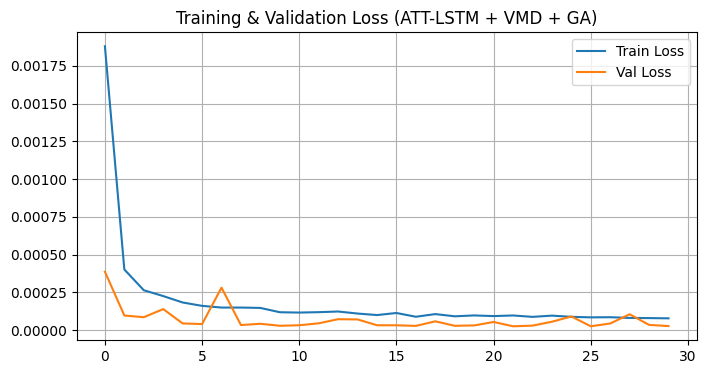

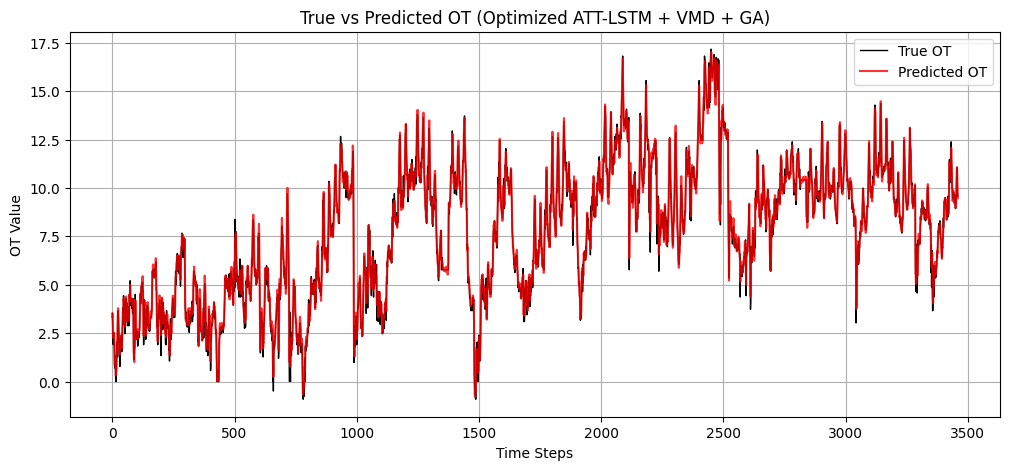

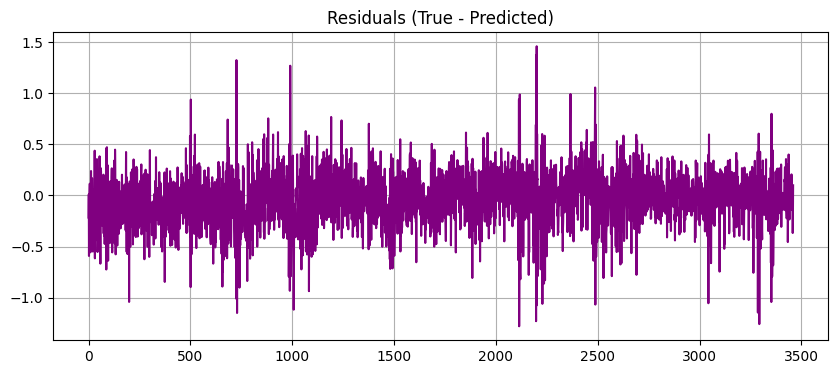

In [24]:
# =====================================================
# 7️⃣ Retrain with Best Params (no leakage)
# =====================================================
alpha, tau, K = best_params['alpha'], best_params['tau'], best_params['K']
lstm1_units, lstm2_units, dense_units = (
    best_params['lstm1_units'], best_params['lstm2_units'], best_params['dense_units']
)

y_test_vmd_true,_,scaler_y,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha, tau, K) 


model = build_attlstm_model((SEQ_LEN, K), lstm1_units, lstm2_units, dense_units)
model.summary()

history_attlstm_vmd_ga = model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS_FINAL,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict (inverse-transform from original OT scaling)
y_pred_attlstm_vmd_ga_scaled = model.predict(X_test_vmd)
y_pred_attlstm_vmd_ga_true = scaler_y.inverse_transform(y_pred_attlstm_vmd_ga_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_vmd_ga.history['loss'], label='Train Loss')
plt.plot(history_attlstm_vmd_ga.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + VMD + GA)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_vmd_ga_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + VMD + GA)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_attlstm_vmd_ga_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

# AttnLSTM+SIMPLE+GA

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from vmdpy import VMD
import random

# =====================================================
# 1️⃣ Global Config
# =====================================================
SEQ_LEN = SEQ_LEN        # sequence length
EPOCHS_OPT = 4           # epochs during GA fitness
EPOCHS_FINAL = EPOCHS    # final retraining

# =====================================================
# 2️⃣ ATT-LSTM Model Builder
# =====================================================
def build_attlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32):
    inp = Input(shape=input_shape)
    lstm_out = LSTM(lstm1_units, return_sequences=True)(inp)
    lstm_out = Dropout(0.2)(lstm_out)

    # Attention
    query = Dense(lstm1_units)(lstm_out)
    value = Dense(lstm1_units)(lstm_out)
    attention_out = Attention()([query, value])
    attention_out = Concatenate()([lstm_out, attention_out])

    # Decoder
    lstm_dec = LSTM(lstm2_units, return_sequences=False)(attention_out)
    dense_out = Dense(dense_units, activation='relu')(lstm_dec)
    final_out = Dense(1)(dense_out)

    model = Model(inputs=inp, outputs=final_out)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
    return model

# =====================================================
# 4️⃣ Fitness Function (GA objective)
# =====================================================
def fitness(params, data):
    lstm1_units, lstm2_units, dense_units = (
        params['lstm1_units'], params['lstm2_units'], params['dense_units']
    )
    
    _,y_test_simple_true,scaler_y,_,_,_,_,X_train_simple,y_train_simple,X_test_simple,y_test_simple = train_test() 
   
    # --- Model ---
    k = 1
    model = build_attlstm_model(
        (SEQ_LEN, K),
        lstm1_units=lstm1_units,
        lstm2_units=lstm2_units,
        dense_units=dense_units
    )

    history = model.fit(
        X_train_simple, y_train_simple,
        validation_data=(X_test_simple, y_test_simple),
        epochs=EPOCHS_OPT,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    mse = min(history.history['val_loss'])
    return mse

# =====================================================
# 5️⃣ Genetic Algorithm (GA)
# =====================================================
def random_params():
    return {
        
        'lstm1_units': random.choice([64, 96, 128, 160]),
        'lstm2_units': random.choice([32, 48, 64, 96]),
        'dense_units': random.choice([16, 32, 48, 64])
    }

def mutate(params):
    new_params = params.copy()
    if random.random() < 0.4:
        new_params['lstm1_units'] = random.choice([64, 96, 128, 160])
    if random.random() < 0.4:
        new_params['lstm2_units'] = random.choice([32, 48, 64, 96])
    if random.random() < 0.4:
        new_params['dense_units'] = random.choice([16, 32, 48, 64])
    return new_params

def evolve_population(data, pop_size=4, generations=3):
    population = [random_params() for _ in range(pop_size)]
    for g in range(generations):
        print(f"\n🧬 Generation {g+1}/{generations}")
        scores = []
        for i, params in enumerate(population):
            mse = fitness(params, data)
            scores.append((mse, params))
            print(f"  Candidate {i+1}: MSE = {mse:.4f}, params = {params}")
        scores.sort(key=lambda x: x[0])
        best_params = scores[0][1]
        print(f"  ✅ Best so far: {best_params}")
        # Evolve
        new_pop = [scores[0][1], scores[1][1]]
        while len(new_pop) < pop_size:
            parent = random.choice(new_pop)
            new_pop.append(mutate(parent))
        population = new_pop
    return best_params

# =====================================================
# 6️⃣ Run Optimization
# =====================================================
best_params = evolve_population(df, pop_size=4, generations=3)
print("\n🏁 Best parameters found:", best_params)


🧬 Generation 1/3
  Candidate 1: MSE = 0.0003, params = {'lstm1_units': 160, 'lstm2_units': 48, 'dense_units': 16}
  Candidate 2: MSE = 0.0002, params = {'lstm1_units': 128, 'lstm2_units': 48, 'dense_units': 16}
  Candidate 3: MSE = 0.0003, params = {'lstm1_units': 64, 'lstm2_units': 96, 'dense_units': 48}
  Candidate 4: MSE = 0.0003, params = {'lstm1_units': 128, 'lstm2_units': 48, 'dense_units': 32}
  ✅ Best so far: {'lstm1_units': 128, 'lstm2_units': 48, 'dense_units': 16}

🧬 Generation 2/3
  Candidate 1: MSE = 0.0003, params = {'lstm1_units': 128, 'lstm2_units': 48, 'dense_units': 16}
  Candidate 2: MSE = 0.0002, params = {'lstm1_units': 160, 'lstm2_units': 48, 'dense_units': 16}
  Candidate 3: MSE = 0.0003, params = {'lstm1_units': 160, 'lstm2_units': 48, 'dense_units': 16}
  Candidate 4: MSE = 0.0002, params = {'lstm1_units': 160, 'lstm2_units': 48, 'dense_units': 16}
  ✅ Best so far: {'lstm1_units': 160, 'lstm2_units': 48, 'dense_units': 16}

🧬 Generation 3/3
  Candidate 1: MSE 

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_55      │ (None, 24, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_112 (LSTM)     │ (None, 24, 160)   │    108,160 │ input_layer_55[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_62          │ (None, 24, 160)   │          0 │ lstm_112[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_207 (Dense)   │ (None, 24, 160)   │     25,760 │ dropout_62[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_208 (Dense)   │ (None, 24, 160)   │     25,760 │ dropout_62[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_49        │ (None, 24, 160)   │          0 │ dense_207[0][0],  │
│ (Attention)         │                   │            │ dense_208[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_49      │ (None, 24, 320)   │          0 │ dropout_62[0][0], │
│ (Concatenate)       │                   │            │ attention_49[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_113 (LSTM)     │ (None, 96)        │    160,128 │ concatenate_49[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_209 (Dense)   │ (None, 48)        │      4,656 │ lstm_113[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_210 (Dense)   │ (None, 1)         │         49 │ dense_209[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 324,513 (1.24 MB)

 Trainable params: 324,513 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0095 - mae: 0.0560 - val_loss: 5.4954e-04 - val_mae: 0.0176
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 9.7188e-04 - mae: 0.0233 - val_loss: 6.5402e-04 - val_mae: 0.0218
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 6.9879e-04 - mae: 0.0198 - val_loss: 2.2452e-04 - val_mae: 0.0105
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 5.5320e-04 - mae: 0.0171 - val_loss: 1.9315e-04 - val_mae: 0.0096
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 5.1841e-04 - mae: 0.0167 - val_loss: 2.1012e-04 - val_mae: 0.0105
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 4.9756e-04 - mae: 0.0163 - val_loss: 1.7548e-04 - val_mae: 0.0092
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 5.2605e-04 - mae: 0.0168 - val_loss: 1.8013e-04 - val_mae: 0.0094
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 4.8068e-04 - mae: 0.0157 - val_loss: 2.9812e-04 - val_

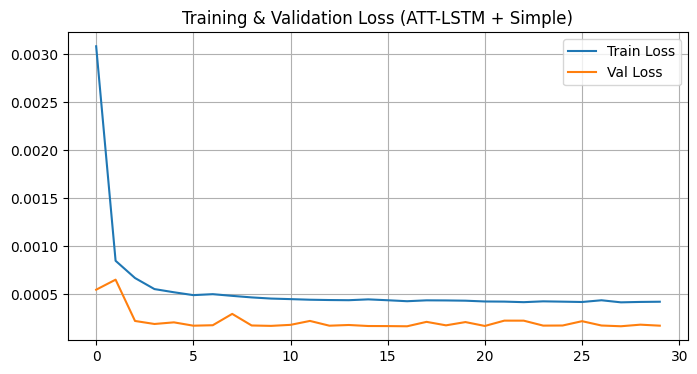

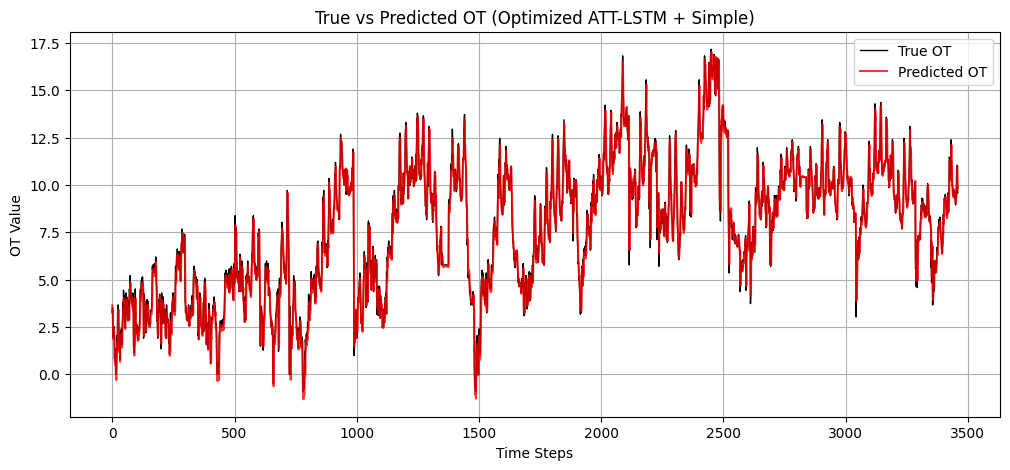

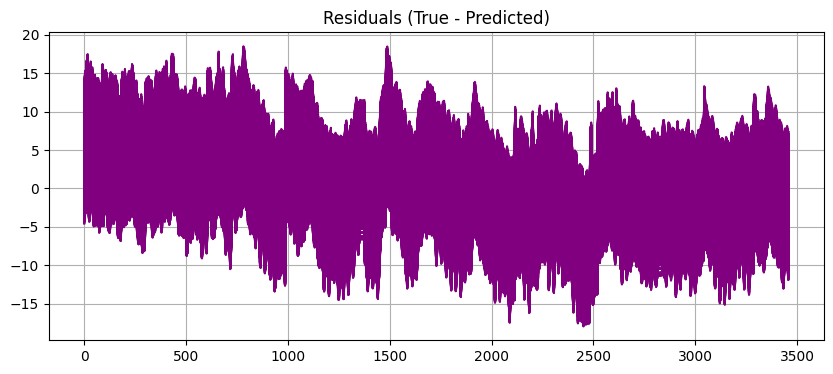

In [29]:
# =====================================================
# 7️⃣ Retrain with Best Params (no leakage)
# =====================================================
lstm1_units, lstm2_units, dense_units = (
    best_params['lstm1_units'], best_params['lstm2_units'], best_params['dense_units']
)

_,y_test_simple_true,scaler_y,_,_,_,_,X_train_simple,y_train_simple,X_test_simple,y_test_simple = train_test() 

k = 1
model = build_attlstm_model((SEQ_LEN, K), lstm1_units, lstm2_units, dense_units)
model.summary()

history_attlstm_simple = model.fit(
    X_train_simple, y_train_simple,
    validation_data=(X_test_simple, y_test_simple),
    epochs=EPOCHS_FINAL,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict (inverse-transform from original OT scaling)
y_pred_attlstm_simple_ga_scaled = model.predict(X_test_simple)
y_pred_attlstm_simple_ga_true = scaler_y.inverse_transform(y_pred_attlstm_simple_ga_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_simple.history['loss'], label='Train Loss')
plt.plot(history_attlstm_simple.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + Simple)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_simple_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_simple_ga_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + Simple)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_simple_true - y_pred_attlstm_simple_ga_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

# LSTM+SIMPLE

/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 244)        │       121,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 24, 244)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_105 (LSTM)                 │ (None, 24, 122)        │       179,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_106 (LSTM)                 │ (None, 24, 64)         │        47,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_107 (LSTM)                 │ (None, 122)            │        91,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 122)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 32)             │         3,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443,217 (1.69 MB)

 Trainable params: 443,217 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0104 - val_loss: 8.1963e-04
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0016 - val_loss: 5.4829e-04
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 9.9348e-04 - val_loss: 4.6251e-04
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 9.0408e-04 - val_loss: 4.1276e-04
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 8.6000e-04 - val_loss: 4.4142e-04
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 8.2519e-04 - val_loss: 6.9820e-04
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 7.2402e-04 - val_loss: 4.5304e-04
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 7.5837e-04 - val_loss: 2.1729e-04
Epoch 9/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 7.2806e-04 - val_loss: 5.3401e-04
Epoch 10/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 6.5956e-04 - val_loss: 2.0773e-04
Epoch 11/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - l

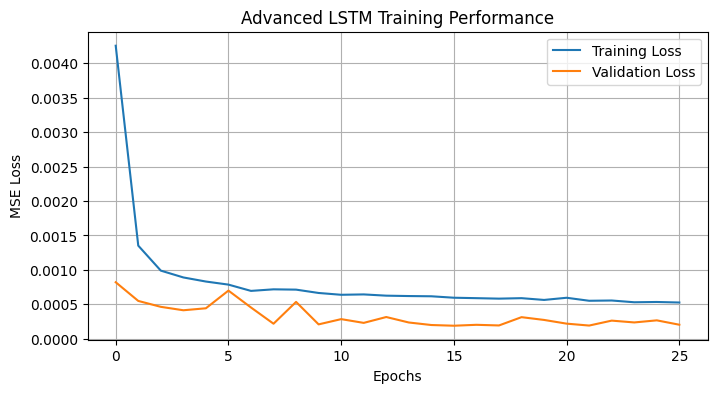

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


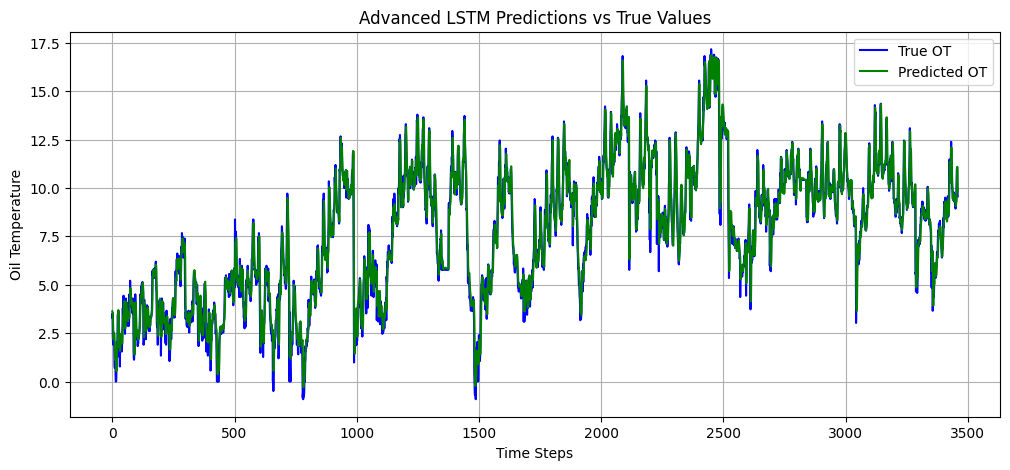

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

_,y_test_simple_true,scaler_y,_,_,_,_,X_train_simple,y_train_simple,X_test_simple,y_test_simple = train_test() 

# Advanced LSTM model
advanced_lstm = Sequential([
    Bidirectional(LSTM(122, return_sequences=True), input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(122, return_sequences=True),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(122, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

advanced_lstm.compile(optimizer='adam', loss='mse')
advanced_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history_lstm_simple = advanced_lstm.fit(
    X_train_simple, y_train_simple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_simple, y_test_simple),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history_lstm_simple.history['loss'], label='Training Loss')
plt.plot(history_lstm_simple.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Advanced LSTM Training Performance')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
y_pred_scaled_lstm = advanced_lstm.predict(X_test_simple)
y_pred_lstm_simple_true = scaler_y.inverse_transform(y_pred_scaled_lstm.reshape(-1, 1)).flatten()

# Plot predictions vs true values
plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label='True OT', color='blue')
plt.plot(y_pred_lstm_simple_true, label='Predicted OT', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Advanced LSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()


# LSTM+VMD

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 24, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 24, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,809 (780.50 KB)

 Trainable params: 199,809 (780.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0078 - mae: 0.0517 - val_loss: 2.2306e-04 - val_mae: 0.0112
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0010 - mae: 0.0242 - val_loss: 1.4194e-04 - val_mae: 0.0093
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 6.8879e-04 - mae: 0.0198 - val_loss: 9.0254e-05 - val_mae: 0.0072
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 6.8253e-04 - mae: 0.0194 - val_loss: 7.1313e-05 - val_mae: 0.0062
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 5.6287e-04 - mae: 0.0177 - val_loss: 1.1141e-04 - val_mae: 0.0084
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 5.1682e-04 - mae: 0.0171 - val_loss: 1.5293e-04 - val_mae: 0.0100
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.6775e-04 - mae: 0.0163 - val_loss: 6.5922e-05 - val_mae: 0.0060
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.2914e-04 - mae: 0.0153 - val_loss: 9.3586e-05 - val_mae:

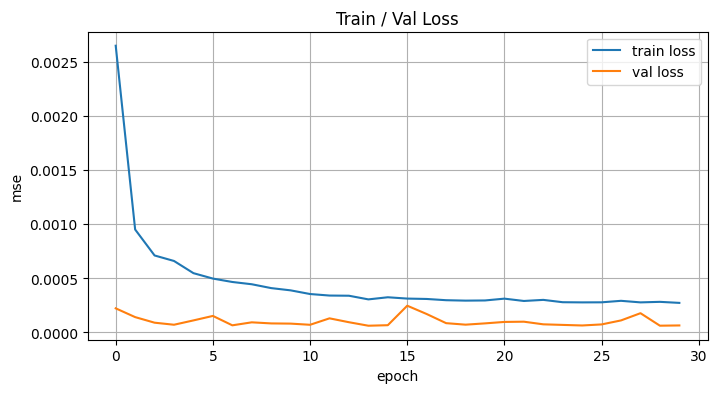

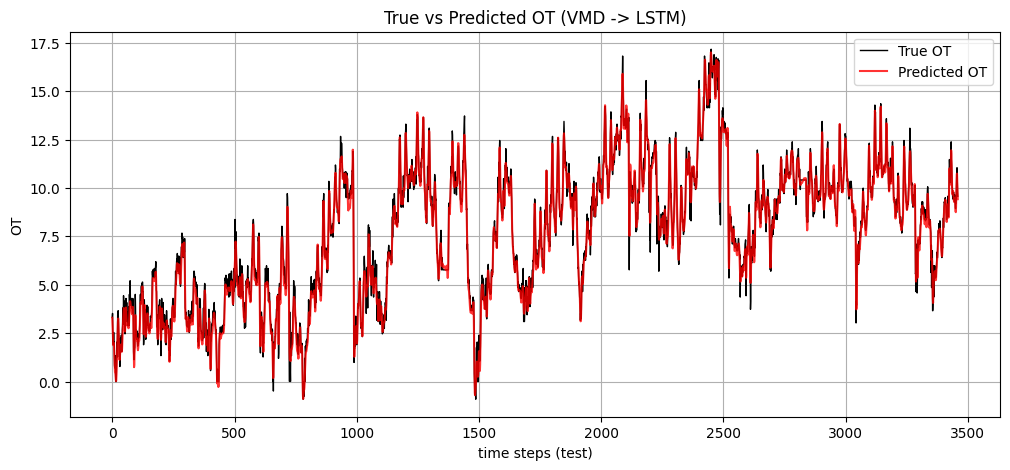

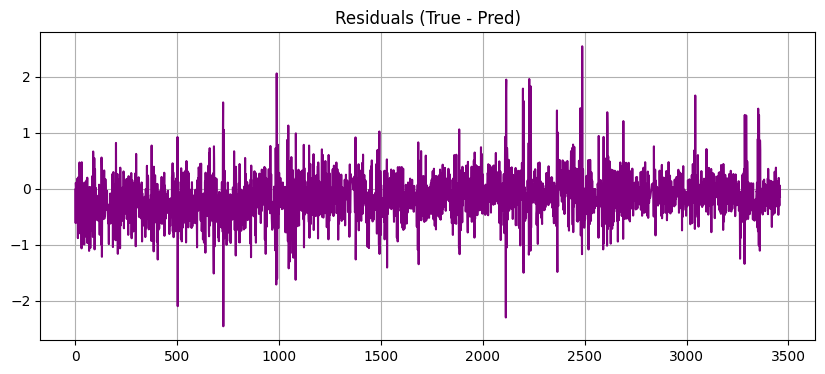

In [17]:
# Code: VMD -> LSTM (no leakage)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from vmdpy import VMD
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


_,y_test_vmd_true,_,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha, tau, K)

# ---------------------------
# 5. Build LSTM model
# ---------------------------
def build_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = LSTM(units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

model = build_lstm_model((SEQ_LEN, K))
model.summary()

# ---------------------------
# 6. Train
# ---------------------------
history_lstm_vmd = model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# ---------------------------
# 7. Predict & inverse-transform
# ---------------------------
y_pred_lstm_vmd_scaled = model.predict(X_test_vmd)
y_pred_lstm_vmd_true = scaler_y.inverse_transform(y_pred_lstm_vmd_scaled).flatten()

# ---------------------------
# 9. Plots
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(history_lstm_vmd.history['loss'], label='train loss')
plt.plot(history_lstm_vmd.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('mse'); plt.legend(); plt.grid(True)
plt.title('Train / Val Loss')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_simple_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_lstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.xlabel('time steps (test)')
plt.ylabel('OT')
plt.title('True vs Predicted OT (VMD -> LSTM)')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_pred_lstm_vmd_true - y_test_vmd_true
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()


# XLSTM_VMD

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xlstm_9 (XLSTM)                 │ (None, 24, 128)        │        71,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xlstm_10 (XLSTM)                │ (None, 24, 128)        │       148,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xlstm_11 (XLSTM)                │ (None, 24, 64)         │        57,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_125 (LSTM)                 │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,833 (1.19 MB)

 Trainable params: 312,833 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0138 - val_loss: 0.0014
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0012 - val_loss: 4.5614e-04
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 7.8334e-04 - val_loss: 1.8731e-04
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 5.4494e-04 - val_loss: 1.4495e-04
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 4.7160e-04 - val_loss: 9.6211e-05
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 3.8598e-04 - val_loss: 1.1888e-04
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 3.4908e-04 - val_loss: 8.2888e-05
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 2.9851e-04 - val_loss: 9.5457e-05
Epoch 9/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 3.0118e-04 - val_loss: 3.2857e-04
Epoch 10/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 3.0244e-04 - val_loss: 1.0072e-04
Epoch 11/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss:

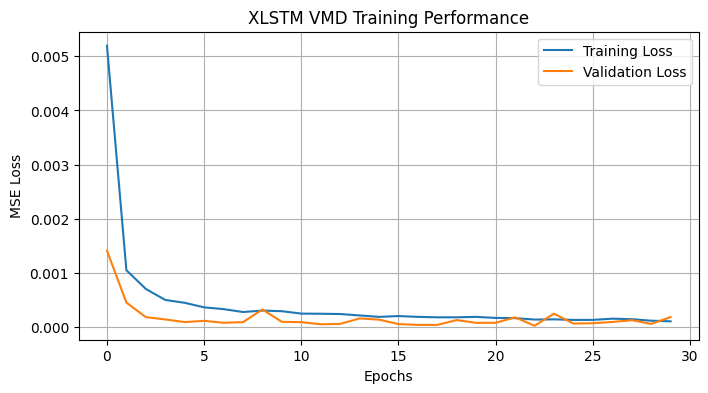

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


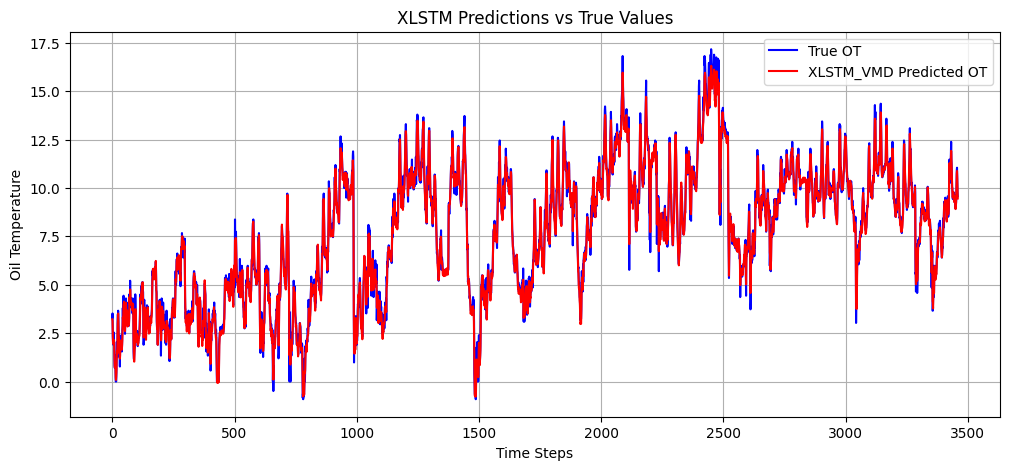

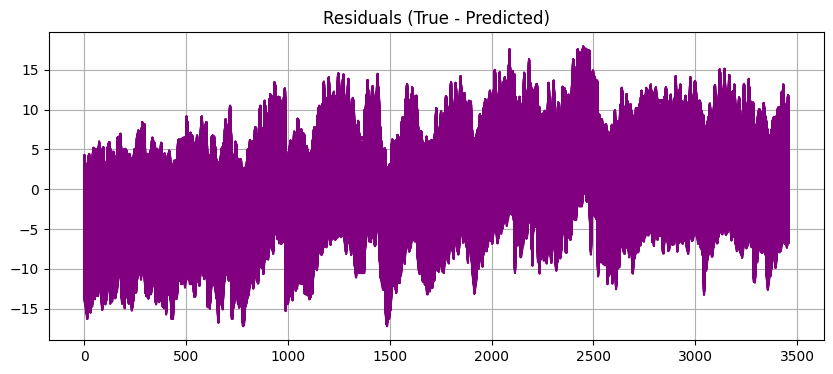

In [33]:
from tensorflow.keras.layers import Layer, LSTM, Dense, LayerNormalization, Dropout

class XLSTM(Layer):
    def __init__(self, units, dropout=0.1, **kwargs):
        super(XLSTM, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout

        self.lstm = LSTM(units, return_sequences=True)
        self.dropout_layer = Dropout(dropout)
        self.norm = LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]    # <-- Detect feature count automatically

        # Projection for residual connection
        self.proj = Dense(self.units)  # input_dim → units

        super().build(input_shape)

    def call(self, x):
        h = self.lstm(x)
        h = self.dropout_layer(h)

        h_res = self.proj(x)   # Now works for any feature dimension

        return self.norm(h + h_res)


# =============================
# XLSTM Model
# =============================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Load data
_,y_test_simple_true,scaler_y,_,_,_,_,X_train_simple,y_train_simple,X_test_simple,y_test_simple = train_test()

# -----------------------------
# XLSTM Model Architecture
# -----------------------------

xlstm_model = Sequential([
    Input(shape=(SEQ_LEN, X_train_vmd.shape[-1])),  # automatic feature count
    XLSTM(128, dropout=0.2),
    XLSTM(128, dropout=0.2),
    XLSTM(64, dropout=0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

xlstm_model.compile(optimizer='adam', loss='mse')
xlstm_model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train XLSTM
history_xlstm_vmd = xlstm_model.fit(
    X_train_vmd, y_train_vmd,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_vmd, y_test_vmd),
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(8, 4))
plt.plot(history_xlstm_vmd.history['loss'], label='Training Loss')
plt.plot(history_xlstm_vmd.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('XLSTM VMD Training Performance')
plt.legend()
plt.grid(True)
plt.show()

y_pred_xlstm_vmd_scaled = xlstm_model.predict(X_test_vmd)
y_pred_xlstm_vmd_true = scaler_y.inverse_transform(y_pred_xlstm_vmd_scaled.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label='True OT', color='blue')
plt.plot(y_pred_xlstm_vmd_true, label='XLSTM_VMD Predicted OT', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('XLSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_xlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


# Compare Models

📈 Model Performance Comparison
ATT-LSTM-VMD-GA: MSE=0.0689, RMSE=0.2624, MAE=0.1977, R²=0.9940
Lstm_Simple: MSE=0.4720, RMSE=0.6870, MAE=0.4743, R²=0.9585
Attlstm_Simple_GA: MSE=0.4405, RMSE=0.6637, MAE=0.4574, R²=0.9634
Lstm_vmd: MSE=0.1625, RMSE=0.4031, MAE=0.2998, R²=0.9866
XLstm_vmd: MSE=0.0726, RMSE=0.2694, MAE=0.1966, R²=0.9938


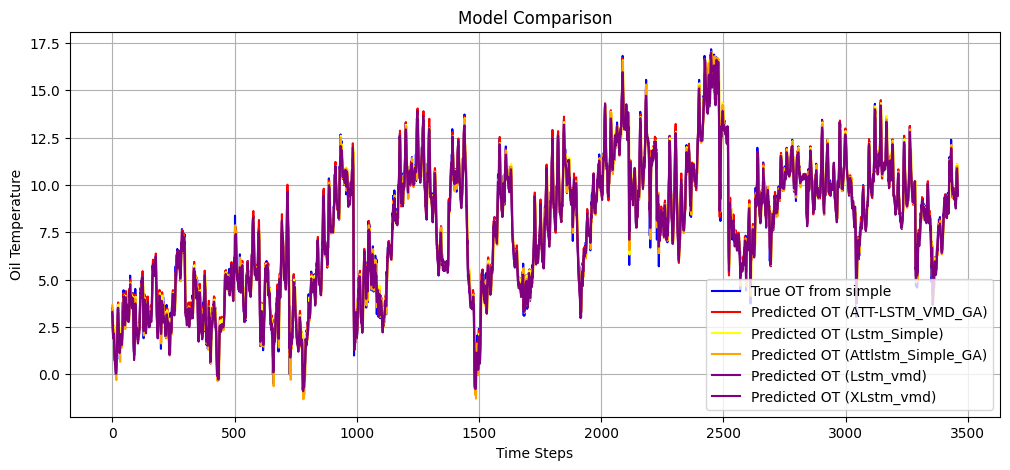

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_metrics(y_true, y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Compute metrics
mse_Attlstm_vmd_ga, rmse_Attlstm_vmd_ga, mae_Attlstm_vmd_ga, r2_attlstm_vmd_ga = compute_metrics(y_pred_attlstm_vmd_ga_true, y_test_vmd_true)
mse_Lstm_simple, rmse_Lstm_simple, mae_Lstm_simple, r2_Lstm_simple = compute_metrics(y_pred_lstm_simple_true, y_test_simple_true)
mse_Attlstm_simple_ga, rmse_Attlstm_simple_ga, mae_Attlstm_simple_ga, r2_attlstm_simple_ga = compute_metrics(y_pred_attlstm_simple_ga_true, y_test_simple_true)
mse_Lstm_vmd, rmse_Lstm_vmd, mae_Lstm_vmd, r2_Lstm_vmd = compute_metrics(y_pred_lstm_vmd_true, y_test_vmd_true)
mse_XLstm_vmd, rmse_XLstm_vmd, mae_XLstm_vmd, r2_XLstm_vmd = compute_metrics(y_pred_xlstm_vmd_true, y_test_vmd_true)

# Print comparison
print("📈 Model Performance Comparison")
print(f"ATT-LSTM-VMD-GA: MSE={mse_Attlstm_vmd_ga:.4f}, RMSE={rmse_Attlstm_vmd_ga:.4f}, MAE={mae_Attlstm_vmd_ga:.4f}, R²={r2_attlstm_vmd_ga:.4f}")
print(f"Lstm_Simple: MSE={mse_Lstm_simple:.4f}, RMSE={rmse_Lstm_simple:.4f}, MAE={mae_Lstm_simple:.4f}, R²={r2_Lstm_simple:.4f}")
print(f"Attlstm_Simple_GA: MSE={mse_Attlstm_simple_ga:.4f}, RMSE={rmse_Attlstm_simple_ga:.4f}, MAE={mae_Attlstm_simple_ga:.4f}, R²={r2_attlstm_simple_ga:.4f}")
print(f"Lstm_vmd: MSE={mse_Lstm_vmd:.4f}, RMSE={rmse_Lstm_vmd:.4f}, MAE={mae_Lstm_vmd:.4f}, R²={r2_Lstm_vmd:.4f}")
print(f"XLstm_vmd: MSE={mse_XLstm_vmd:.4f}, RMSE={rmse_XLstm_vmd:.4f}, MAE={mae_XLstm_vmd:.4f}, R²={r2_XLstm_vmd:.4f}")


plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label='True OT from simple', color='blue')
plt.plot(y_pred_attlstm_vmd_ga_true, label='Predicted OT (ATT-LSTM_VMD_GA)', color='red')
plt.plot(y_pred_lstm_simple_true[:len(y_test_simple_true)], label='Predicted OT (Lstm_Simple)', color='yellow')
plt.plot(y_pred_attlstm_simple_ga_true[:len(y_test_simple_true)], label='Predicted OT (Attlstm_Simple_GA)', color='orange')
plt.plot(y_pred_lstm_vmd_true[:len(y_test_vmd_true)], label='Predicted OT (Lstm_vmd)', color='purple')
plt.plot(y_pred_xlstm_vmd_true[:len(y_test_vmd_true)], label='Predicted OT (XLstm_vmd)', color='purple')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Model Comparison')
plt.legend()
plt.grid(True)
plt.show()


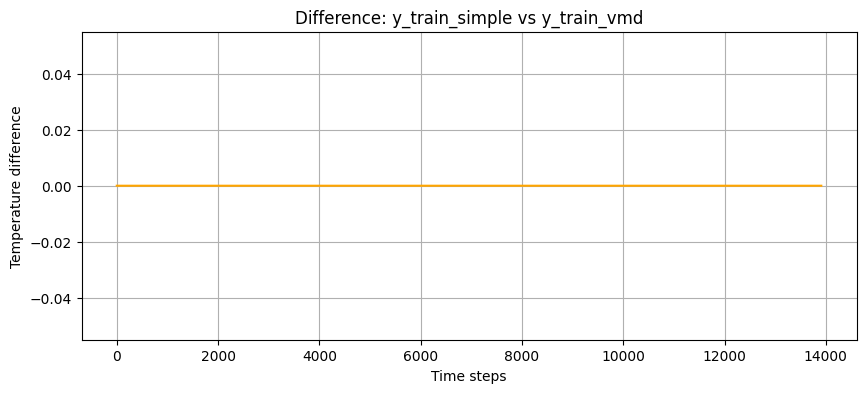

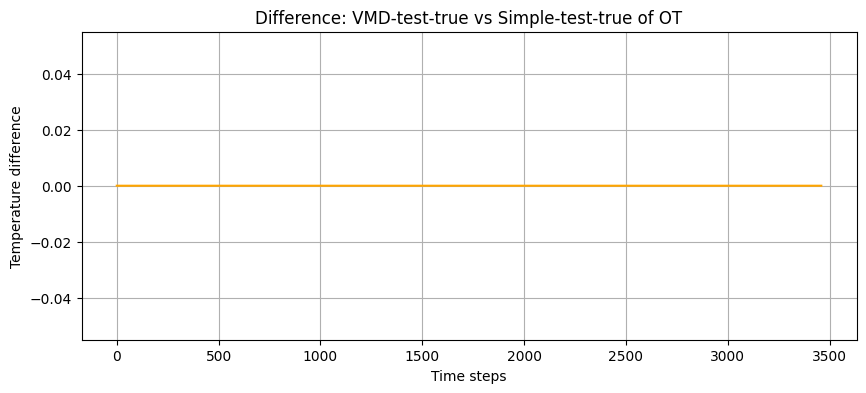

In [35]:
diff = y_train_simple - y_train_vmd
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: y_train_simple vs y_train_vmd')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()

y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd)
y_test_simple_true = scaler_y.inverse_transform(y_test_simple)
diff = y_test_simple_true - y_test_vmd_true
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: VMD-test-true vs Simple-test-true of OT')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()